# Indus Valley Scripts - ICIT coded Text Analysis for Decipherment

# Textual Analysis

Dataset was created as a csv file from ICIT web site from raw html files for each for the Text
Data labels were changes and a linearized copy of the original text was added

icit_text_text_corpus.csv


!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install nltk
!pip install ipywidgets
!pip install -U dill
!pip3 install requests
!pip3 install -U spacy

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import collections
import traceback

plt.style.use(style='seaborn')
%matplotlib inline

In [2]:
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten
from collections import defaultdict

In [3]:
CONST_NL=10 #Normalized length

In [4]:
# Set the filters on data here
drop_duplicate_texts = True

filter_by_site = False
filter_by_keywords = False
filter_by_text_length = True

#site = 'Mohenjo-daro'
site = 'Harappa'
keyword = "Bull1"

min_text_length=0
max_text_length=50

num_rows= 4999

In [5]:
orig_df=pd.read_csv('../../IndusCorpusUtils/data/icit_corpus/icit_text_text_corpus.csv',dtype=str, nrows=num_rows)
# set the max columns to none
pd.set_option('display.max_columns', None)

In [6]:
#Reverse text and add that as a new column
# Add text length as a column
list_reversed_text = []
for text in orig_df[orig_df.r_to_l_text!=''].r_to_l_text:
    # Tokenize to words
    # first split the string into chars
    chars = text.split(' ')
    length = len(chars)
    # then reverse the split string list and join with a space
    reversed_text = ' '.join(reversed(chars))
    list_reversed_text.append(reversed_text)
    
orig_df['reversed_text']= list_reversed_text


orig_df['text_length']= orig_df['l_to_r_text'].str.len().div(3).round()


print("Dataframe has ", len(orig_df.index), " rows")

orig_df.head()
orig_df.info

Dataframe has  4999  rows


<bound method DataFrame.info of      icit_id        site keywords text_class lines direction       text signs  \
0          1  Alamgirpur      NaN         SS     1       L/R  +410-017+     2   
1          2  Alamgirpur      NaN         SS     1       L/R  +410-017+     2   
2          3  Alamgirpur      NaN         SC     1       L/R  +405-017+     2   
3          4   Allahdino      NaN         ??     1       NaN  +220-000+     1   
4          5   Allahdino     Bull         UC     1       R/L  +740-235+     2   
...      ...         ...      ...        ...   ...       ...        ...   ...   
4994    4064     Harappa      NaN         UC     1       NaN      +000[     0   
4995    4065     Harappa      NaN         VN     1       R/L  ]700-032[     2   
4996    4065     Harappa      NaN         UC     1       R/L  ]000-000[     0   
4997    4066     Harappa      NaN         UC     1       R/L  +368-000+     1   
4998    4066     Harappa      NaN         VN     1       R/L  +700-033+     2

In [7]:
# Retain texts that are only wanted

#remove the values where the text is unclear
df = orig_df[orig_df['r_to_l_text'].str.contains('000') == False] 

print("After removing unclear texts, we have ", len(df.index), " rows")

if(drop_duplicate_texts):
    #Remove out duplicate inplace
    df = df.drop_duplicates(subset ="text",
                         keep = False, inplace = False)

    print("After removing duplicate texts, we have ", len(df.index), " rows")


#keep only the values that does not have multi-line text
df = df[df['text'].str.contains('/') == False] 

print("After removing multi-line text, we have ", len(df.index), " rows")


#keep only the values where the direction is known (if direction does not have a /, i,e. L/R or R/L)
#Btw standardized_text is Left to right as in English
df = df[df['direction'].str.contains('/') == True] 

print("After keeping only text with known direction, we have ", len(df.index), " rows")

#Remove Multipart texts that have [ or ]
df = df[df['text'].str.contains("\[") == False] 
df = df[df['text'].str.contains("\]") == False] 

print("After keeping only text without multipart, we have ", len(df.index), " rows")


After removing unclear texts, we have  3945  rows
After removing duplicate texts, we have  2130  rows
After removing multi-line text, we have  2053  rows
After keeping only text with known direction, we have  1813  rows
After keeping only text without multipart, we have  1566  rows


In [8]:
# of those whose direction is know print out L/R and L/R text count
df_l_r = df[df['direction'].str.contains('L/R') == True] 

print("L/R texts: ", len(df_l_r.index))

df_r_l = df[df['direction'].str.contains('R/L') == True]

print("R/L texts: ", len(df_r_l.index))

L/R texts:  58
R/L texts:  1502


In [9]:
if(filter_by_site==True):
    #keep only the values that matches the provided site
    df = df[df['site'].str.contains(site) == True] 
    print("After filtering by site ", site, " it has ", len(df.index), " rows")

if(filter_by_keywords==True):
     #keep only the values that matches the provided keyword
    df = df[df['keywords'].str.contains(keyword) == True] 
    print("After filtering by keywords ", keyword, " it has ", len(df.index), " rows")

if(filter_by_text_length==True):
    df = df[(df['text_length'] > min_text_length) & (df['text_length']< max_text_length)]
    print("After filtering by text_length ",  " it has ", len(df.index), " rows")
    
print(df)

After filtering by text_length   it has  1566  rows
     icit_id          site keywords text_class lines direction  \
4          5     Allahdino     Bull         UC     1       R/L   
6          7     Allahdino    Bull1         SC     1       R/L   
7          8     Allahdino    Bull1         PP     1       R/L   
8          9     Allahdino    Bull1         LP     1       R/L   
9         10     Allahdino    Bull1         SS     1       R/L   
...      ...           ...      ...        ...   ...       ...   
4949    4030  Mohenjo-daro      NaN         SC     1       R/L   
4952    4032  Mohenjo-daro      NaN         UC     1       R/L   
4959    4039  Mohenjo-daro      NaN         SC     1       R/L   
4967    4047  Mohenjo-daro      NaN         SC     1       R/L   
4985    4059       Harappa      NaN         SP     1       R/L   

                           text signs complete alignment sign height  \
4                     +740-235+     2        Y       NaN         NaN   
6          

In [10]:
#Keep the items with unclear text in another dataframe
df_unclear = orig_df[orig_df['r_to_l_text'].str.contains('000') == True]

#Note: Lot of the text with unclear text have direction empty

### Feature Extraction

In [11]:
y=df['site'].values
y.shape

# y axis is still the same
y_rev=df['site'].values
y_rev.shape

(1566,)

In [12]:
x=df['r_to_l_text'].values
x.shape

x_rev=df['reversed_text'].values
x_rev.shape

(1566,)

### Train-test split for doing cluster, model analysis for later

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
(x_train,x_test,y_train,y_test)=train_test_split(x,y,test_size=0.1, random_state=43)

(x_rev_train,x_rev_test,y_rev_train,y_rev_test)=train_test_split(x_rev,y_rev,test_size=0.1, random_state=43)

In [15]:
#Train data, fwd and reverse
df_train_x=pd.DataFrame(x_train)
df_train_x=df_train_x.rename(columns={0:'r_to_l_text'})

df_train_y=pd.DataFrame(y_train)
df_train_y=df_train_y.rename(columns={0:'site'})

df_train_x_rev=pd.DataFrame(x_rev_train)
df_train_x_rev=df_train_x_rev.rename(columns={0:'reversed_text'})

df_train_y_rev=pd.DataFrame(y_rev_train)
df_train_y_rev=df_train_y_rev.rename(columns={0:'site'})

#Test data, fwd and reverse
df_test_x=pd.DataFrame(x_test)
df_test_x=df_test_x.rename(columns={0:'r_to_l_text'})

df_test_y=pd.DataFrame(y_test)
df_test_y=df_test_y.rename(columns={0:'site'})

df_test_x_rev=pd.DataFrame(x_rev_test)
df_test_x_rev=df_test_x_rev.rename(columns={0:'reversed_text'})

df_test_y_rev=pd.DataFrame(y_rev_test)
df_test_y_rev=df_test_y_rev.rename(columns={0:'site'})

In [16]:
df_train=pd.concat([df_train_x,df_train_y],axis=1)
#print(df_train.head())

df_test=pd.concat([df_test_x,df_test_y],axis=1)
#print(df_test.head())

df_train_rev=pd.concat([df_train_x_rev,df_train_y_rev],axis=1)
#print(df_train_rev.head())

df_test_rev=pd.concat([df_test_x_rev,df_test_y_rev],axis=1)
#print(df_test_rev.head())

## First let us do stats on the whole data. Ignore df_train and df_test for now

## Text Length Analysis

In [17]:
def reverse_text(text):
    # first split the string into chars
    chars = text.split(' ')

    # then reverse the split string list and join with a space
    reversed_text = ' '.join(reversed(chars))
    return reversed_text

In [18]:
text_lengths=defaultdict(int)
total_length=0
total_count=0
for text in df[df.r_to_l_text!=''].r_to_l_text:
    chars = text.split(' ')
    length = len(chars)
    text_lengths[length]+=1
    total_length = total_length +length
    total_count = total_count+1

print('Average Text Length:',round(total_length/total_count,2) )
#print(text_lengths.items())

df_text_lengths=pd.DataFrame(sorted(text_lengths.items(),key=lambda x:x[1],reverse=True))
pd_text_lengths1=df_text_lengths[0][:20]
pd_text_lengths2=df_text_lengths[1][:20]

Average Text Length: 4.76


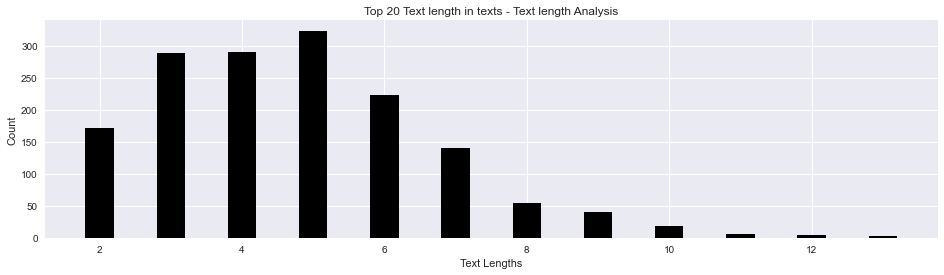

In [19]:
plt.figure(1,figsize=(16,4))

plt.bar(pd_text_lengths1,pd_text_lengths2, color ='black',
        width = 0.4)
 
plt.xlabel("Text Lengths")
plt.ylabel("Count")
plt.title("Top 20 Text length in texts - Text length Analysis")

plt.savefig("text-length.png")
plt.show()

## N Gram Analysis of the Texts

In [20]:
from nltk.tokenize import word_tokenize,sent_tokenize

In [21]:
# Get ngram as list given a text (pass direction_of_string as "R/L" or "L/R")
def get_ngrams_as_list(data,direction_of_string,num):
    
    if(direction_of_string=="R/L"):
        # We need to convert R/L text to L/R to be able to get ngrams using nltk
        data_string = reverse_text(data)
    
    else: data_string= data
    
    n_grams =  ngrams(nltk.word_tokenize(data_string), num)
    return  [ ' '.join(grams) for grams in n_grams]

In [22]:
text_unigrams=defaultdict(int)
text_bigrams=defaultdict(int)
text_trigrams=defaultdict(int)
text_quadgrams=defaultdict(int)

In [23]:
#Tokenize the text

tokenized_text = list(df[df.r_to_l_text!=''].r_to_l_text.apply(word_tokenize))
reverse_tokenized_text = list(df[df.reversed_text!=''].reversed_text.apply(word_tokenize))

#print("tokenized_text:",tokenized_text)

In [24]:
for text in df[df.r_to_l_text!=''].r_to_l_text:
  for word in get_ngrams_as_list(text,"R/L", 1):
    text_unigrams[word]+=1

#text_unigrams.items()

In [25]:
for text in df[df.r_to_l_text!=''].r_to_l_text:
  for word in get_ngrams_as_list(text,"R/L", 2):
    text_bigrams[word]+=1

#text_bigrams.items()

In [26]:
for text in df[df.r_to_l_text!=''].r_to_l_text:
  for word in get_ngrams_as_list(text,"R/L", 3):
    text_trigrams[word]+=1

#text_trigrams.items()

In [27]:
for text in df[df.r_to_l_text!=''].r_to_l_text:
  for word in get_ngrams_as_list(text,"R/L", 4):
    text_quadgrams[word]+=1

#text_quadgrams.items()

In [28]:
df_text_unigrams=pd.DataFrame(sorted(text_unigrams.items(),key=lambda x:x[1],reverse=True))
df_text_bigrams=pd.DataFrame(sorted(text_bigrams.items(),key=lambda x:x[1],reverse=True))
df_text_trigrams=pd.DataFrame(sorted(text_trigrams.items(),key=lambda x:x[1],reverse=True))
df_text_quadgrams=pd.DataFrame(sorted(text_quadgrams.items(),key=lambda x:x[1],reverse=True))

In [29]:
print("Number of distinct Unigrams", len(df_text_unigrams))
print("Number of distinct Bigrams", len(df_text_bigrams))
print("Number of distinct Trigrams", len(df_text_trigrams))
print("Number of distinct Quadgrams", len(df_text_quadgrams))

Number of distinct Unigrams 556
Number of distinct Bigrams 2674
Number of distinct Trigrams 3325
Number of distinct Quadgrams 2710


In [30]:
pd_text_unigrams1=df_text_unigrams[0][:20]
pd_text_unigrams2=df_text_unigrams[1][:20]

pd_text_bigrams1=df_text_bigrams[0][:20]
pd_text_bigrams2=df_text_bigrams[1][:20]

pd_text_trigrams1=df_text_trigrams[0][:10]
pd_text_trigrams2=df_text_trigrams[1][:10]

pd_text_quadgrams1=df_text_quadgrams[0][:10]
pd_text_quadgrams2=df_text_quadgrams[1][:10]

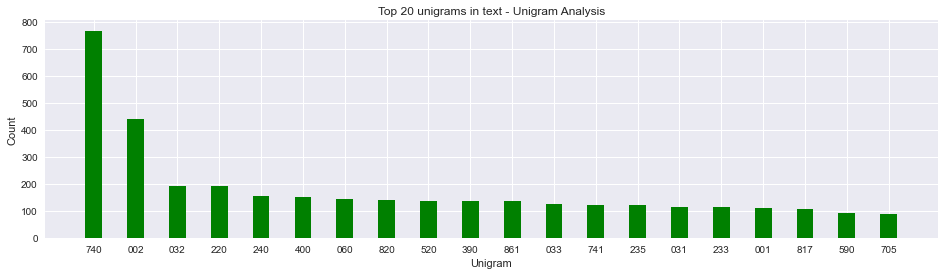

In [31]:
plt.figure(2,figsize=(16,4))

plt.bar(pd_text_unigrams1,pd_text_unigrams2, color ='green',
        width = 0.4)
 
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Top 20 unigrams in text - Unigram Analysis")

plt.savefig("text-unigram.png")
plt.show()

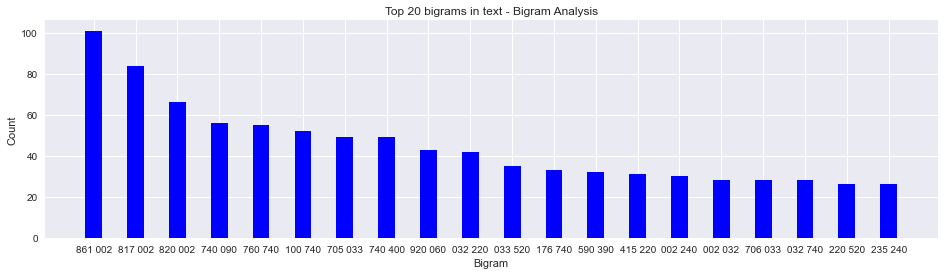

In [32]:
plt.figure(3,figsize=(16,4))

plt.bar(pd_text_bigrams1,pd_text_bigrams2, color ='blue',
        width = 0.4)
 
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.title("Top 20 bigrams in text - Bigram Analysis")

plt.savefig("text-bigram.png")
plt.show()

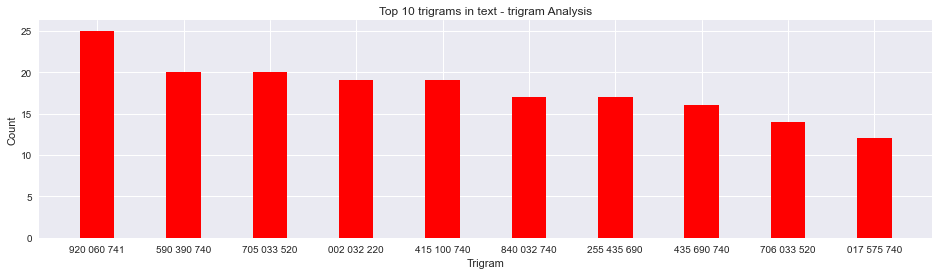

In [33]:
plt.figure(4,figsize=(16,4))

plt.bar(pd_text_trigrams1,pd_text_trigrams2, color ='red',
        width = 0.4)
 
plt.xlabel("Trigram")
plt.ylabel("Count")
plt.title("Top 10 trigrams in text - trigram Analysis")

plt.savefig("text-trigram.png")
plt.show()

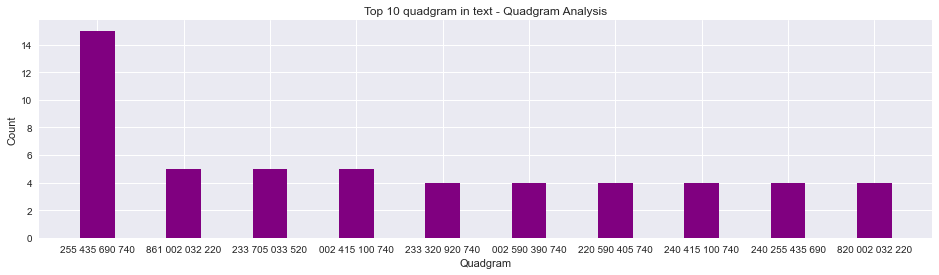

In [34]:
plt.figure(5,figsize=(16,4))

plt.bar(pd_text_quadgrams1,pd_text_quadgrams2, color ='purple',
        width = 0.4)
 
plt.xlabel("Quadgram")
plt.ylabel("Count")
plt.title("Top 10 quadgram in text - Quadgram Analysis")

plt.savefig("text-quadgram.png")
plt.show()

## More Statistical Analysis

# Text Positional Analysis

In [35]:
from typing import Dict

class PositionalNgramModel:
    text_norm_position_unigrams_freq_dict=None
    df_text_norm_position_unigrams_freq=None
    df_text_norm_position_unigrams_prob=None
    text_norm_position_unigrams_maxValueIndex_dict = None
    
    text_norm_position_bigrams_freq_dict = None
    df_text_norm_position_bigrams_freq=None
    df_text_norm_position_bigrams_prob=None
    text_norm_position_bigrams_maxValueIndex_dict = None
    
    text_norm_position_trigrams_freq_dict = None
    df_text_norm_position_trigrams_freq=None
    df_text_norm_position_trigrams_prob=None
    text_norm_position_trigrams_maxValueIndex_dict = None
    
    text_norm_position_quadgrams_freq_dict= None
    df_text_norm_position_quadgrams_freq=None
    df_text_norm_position_quadgrams_prob=None
    text_norm_position_bigrams_maxValueIndex_dict = None
    

    # To get a Positional Number for a unigram, bigram, trigram and Quadgram
    # l = Length of the text
    # s = starting position of the first character of the ngram
    # wp = weighted position = int(s/l)
    # Get the normalized position
    # Since the text passed is L/R,start index i from length of the text
    def get_norm_position(self, text,direction_of_string, search_string):
        num_chars, minp, maxp,w = 0,-1,-1,0
        sp=-1
        index=-1
        pos=-1

        #ngrams which are used as search_strings are generated from left to right, so text need to be changed to L/R
        
        if(direction_of_string=="R/L"):
            new_text = reverse_text(text)
        else: new_text = text
        
            
        l_pos= len(new_text )

        chars = new_text .split(' ')
        num_chars = len(chars)
        w= num_chars/CONST_NL

                
        pos = new_text.find(search_string)
        if(pos<0):  #not found
            return sp, minp, maxp, w
        else: 
            #sp = round((l_pos-pos)/4)
            sp = round(pos/4 +1)

        minp= int((sp-1)* (CONST_NL/num_chars) +1)
        maxp = int(sp*CONST_NL/num_chars)

        #print("text, search_string", new_text ,",", search_string)
        #print("l_pos, pos, sp, minp, maxp", l_pos, pos,sp, minp, maxp)

        if(minp<1): minp=1
        elif(minp>CONST_NL): minp = CONST_NL

        if(maxp<1): maxp=1
        elif(maxp>CONST_NL): maxp = CONST_NL


        return sp,minp, maxp, w


    def get_text_norm_position_ngrams_freq(self,a,direction_of_string, n):

        average_allocation= True # Average out minp and maxp and allocate to the histogram. Don't care about weight

        text_norm_position_ngrams_freq=defaultdict(dict[int, int])
        norm_pos =-1
        i=0
        sp=-1

        try:
            #Fill the values with zeros in decreasing order so that we can keep same order in graph
            for text in a:
              for word in get_ngrams_as_list(text,direction_of_string, n):
                for j in range (10,0, -1):
                    text_norm_position_ngrams_freq[word][j]=0

            for text in a:
              for word in get_ngrams_as_list(text,direction_of_string, n):
                beginning_char = word #Look for position of beginning char of the ngram
                sp,minp, maxp, w = self.get_norm_position(text,direction_of_string, beginning_char)

                if(minp<0 or maxp<0): break #No match


                if(average_allocation):
                    norm_pos = round((minp+ maxp)/2)
                    #print("word, norm_pos", word, norm_pos)
                    val = text_norm_position_ngrams_freq[word].get(norm_pos,0)
                    text_norm_position_ngrams_freq[word][norm_pos]= val+ w
                else:

                    if(minp!=maxp):
                        val = text_norm_position_ngrams_freq[word].get(minp,0)
                        text_norm_position_ngrams_freq[word][minp]= val+ w

                        val = text_norm_position_ngrams_freq[word].get(maxp,0)
                        text_norm_position_ngrams_freq[word][maxp]= val +w
                    else:
                        val = text_norm_position_ngrams_freq[word].get(minp,0)
                        text_norm_position_ngrams_freq[word][minp]= val+ w

                #if(beginning_char=="740"): print(i,":Text:",text, "Char", beginning_char, "sp, minp, maxp, w, norm_pos", sp, minp, maxp, w, norm_pos)

                if(beginning_char=="817 002"): print(i,":Text:",text, "Char:", beginning_char, sp, minp, maxp, w, norm_pos)

                i=i+1

        except Exception as e:
                print("Exception:", e.__class__, "Building the positional ngram Freq")
                traceback.print_exc()

        return  text_norm_position_ngrams_freq

    # Can be generatilzed to any N later
    def fit(self, a, direction_of_string):
        self.text_norm_position_unigrams_freq_dict=defaultdict(dict[int, int])
        self.text_norm_position_unigrams_freq_dict=self.get_text_norm_position_ngrams_freq(a,direction_of_string, 1)
        self.df_text_norm_position_unigrams_freq=pd.DataFrame(self.text_norm_position_unigrams_freq_dict)
        
        self.df_text_norm_position_unigrams_prob = self.df_text_norm_position_unigrams_freq.div(self.df_text_norm_position_unigrams_freq.sum(axis=1), axis=0)
        self.df_text_norm_position_unigrams_prob = self.df_text_norm_position_unigrams_prob.assign(max_value=self.df_text_norm_position_unigrams_prob.values.max(1))
        df_text_norm_position_unigrams_maxValueIndex = self.df_text_norm_position_unigrams_prob.idxmax(axis = 1)
        self.text_norm_position_unigrams_maxValueIndex_dict = df_text_norm_position_unigrams_maxValueIndex.to_dict()
        
        print(self.df_text_norm_position_unigrams_freq)
        print(self.text_norm_position_unigrams_maxValueIndex_dict)
        
        #Bigram
        self.text_norm_position_bigrams_freq_dict=defaultdict(dict[int, int])
        self.text_norm_position_bigrams_freq_dict=self.get_text_norm_position_ngrams_freq(a,direction_of_string,2)
        self.df_text_norm_position_bigrams_freq=pd.DataFrame(self.text_norm_position_bigrams_freq_dict)
        self.df_text_norm_position_bigrams_prob = self.df_text_norm_position_bigrams_freq.div(self.df_text_norm_position_bigrams_freq.sum(axis=1), axis=0)
        #print(self.df_text_norm_position_bigrams_freq)
        
        #Trigram
        self.text_norm_position_trigrams_freq_dict=defaultdict(dict[int, int])
        self.text_norm_position_trigrams_freq_dict=self.get_text_norm_position_ngrams_freq(a,direction_of_string,3)
        self.df_text_norm_position_trigrams_freq=pd.DataFrame(self.text_norm_position_trigrams_freq_dict)
        self.df_text_norm_position_trigrams_prob = self.df_text_norm_position_trigrams_freq.div(self.df_text_norm_position_trigrams_freq.sum(axis=1), axis=0)
        #print(self.df_text_norm_position_trigrams_freq)
        
        #Quadgram
        self.text_norm_position_quadgrams_freq_dict=defaultdict(dict[int, int])
        self.text_norm_position_quadgrams_freq_dict=self.get_text_norm_position_ngrams_freq(a,direction_of_string,4)
        self.df_text_norm_position_quadgrams_freq=pd.DataFrame(self.text_norm_position_quadgrams_freq_dict)
        self.df_text_norm_position_quadgrams_prob = self.df_text_norm_position_quadgrams_freq.div(self.df_text_norm_position_quadgrams_freq.sum(axis=1), axis=0)
        #print(df_text_norm_position_quadgrams_freq)
        
        return self.df_text_norm_position_unigrams_prob, self.df_text_norm_position_bigrams_prob, self.df_text_norm_position_trigrams_prob,self.df_text_norm_position_quadgrams_prob

    def get_text_norm_position_unigrams_char_with_max_prob(self, position):
        char= self.text_norm_position_unigrams_maxValueIndex_dict[position]
        print("Max Prob for Position:", position, "is for character:",char )
        return char
        
    
    def find_characters(self, a, seed):
    #For each of the text with unclear character go through it
    
        ans=-1
        out_char = None
        out_char_list = []
        try:
            for text in a :
                print("Finding Unclear character for", text)
                chars = text.split(' ')
                index = len(chars) - chars.index("000")
                if(index<0):  #not found
                    return 
                else: 
                    # Find the char with highest probablity for this position
                    print(index)
                    out_char = self.get_text_norm_position_unigrams_char_with_max_prob(index)
                    print("Index, out_char:", index, out_char)
                    out_char_list.append(out_char)
    
        except Exception as e:
            print("Exception:", e.__class__, "find_characters")
            
        return  out_char_list

In [36]:

posNgramModel = PositionalNgramModel()

print(posNgramModel.get_norm_position("740 231 220 032 002 817", "R/L", "817 002"))

(1, 1, 1, 0.6)


In [37]:
print(posNgramModel.get_norm_position("853 235 220 740 090", "R/L", "853"))

print(posNgramModel.get_norm_position("740 904 033 705 235", "R/L","235"))

print(posNgramModel.get_norm_position("740 904 033 705 235", "R/L","705"))

print(posNgramModel.get_norm_position("740 904 033 705 235", "R/L","033"))

print(posNgramModel.get_norm_position("740 904 033 705 235", "R/L","033 904"))

print(posNgramModel.get_norm_position("740 904 033 705 235", "R/L","740"))

print(posNgramModel.get_norm_position("740 904 033 705 235", "R/L","123"))

print(posNgramModel.get_norm_position("235 705 033 904 740", "R/L","740"))

(5, 9, 10, 0.5)
(1, 1, 2, 0.5)
(2, 3, 4, 0.5)
(3, 5, 6, 0.5)
(3, 5, 6, 0.5)
(5, 9, 10, 0.5)
(-1, -1, -1, 0.5)
(1, 1, 2, 0.5)


In [38]:
a = df[df.r_to_l_text!=''].r_to_l_text
df_text_norm_position_unigrams_prob, df_text_norm_position_bigrams_prob, df_text_norm_position_trigrams_prob,df_text_norm_position_quadgrams_prob = posNgramModel.fit(a, "R/L")


     235    740   033  125   390  368   705  904  066   741  495   017  510  \
10   0.0  230.8   1.0  1.2  15.6  2.2   0.5  0.8  0.0   0.0  0.0   0.0  0.0   
9    0.0   32.4   0.4  0.0   6.6  0.8   0.0  1.0  0.0   0.0  0.0   0.0  0.0   
8    1.3   72.0  20.0  0.3  19.3  4.1   2.8  5.4  0.0   0.7  0.5   4.5  0.0   
7    1.0    5.3   8.7  0.0   0.0  0.0   3.3  0.0  0.0   0.0  0.0   2.6  0.8   
6   20.0   28.9  20.2  1.7   4.3  2.9  18.1  3.7  0.4  14.5  3.6  11.3  1.1   
5    7.3   11.9   4.0  2.8   1.8  1.5   6.2  0.3  0.3   1.3  0.0   0.6  0.0   
4   20.2   13.7  10.3  2.8   9.5  9.7   9.1  0.4  0.5  34.1  0.6   3.6  0.0   
3    3.3    6.4   0.6  1.0   2.9  0.9   1.2  0.2  0.0   3.2  0.2   0.6  0.0   
2   15.7    9.0   9.3  9.1   8.9  7.1   9.9  5.1  0.5  10.7  1.8   1.8  1.0   
1    4.1    0.7   5.4  5.6   0.6  3.3   4.4  0.8  0.6   6.0  0.6   0.0  0.0   

    460  156  013  840  170  072   415   861    002   032  844  405  413  350  \
10  0.0  1.7  0.0  0.0  0.0  0.5   0.0   2.3    1

4000 :Text: 740 007 503 002 817 Char: 817 002 1 1 2 0.5 2
4009 :Text: 740 354 002 817 Char: 817 002 1 1 2 0.4 2
4185 :Text: 407 061 002 817 Char: 817 002 1 1 2 0.4 2
4233 :Text: 740 100 415 191 002 817 Char: 817 002 1 1 1 0.6 1
4383 :Text: 740 585 017 740 240 002 817 090 370 Char: 817 002 3 3 3 0.9 3
4402 :Text: 520 220 415 519 002 817 Char: 817 002 1 1 1 0.6 1
4541 :Text: 740 585 240 220 032 002 817 Char: 817 002 1 1 1 0.7 1
4588 :Text: 520 400 350 002 817 Char: 817 002 1 1 2 0.5 2
4665 :Text: 740 032 840 585 017 002 817 Char: 817 002 1 1 1 0.7 1
4706 :Text: 679 740 575 017 002 817 Char: 817 002 1 1 1 0.6 1
4720 :Text: 156 260 002 817 Char: 817 002 1 1 2 0.4 2
4763 :Text: 740 690 435 255 002 817 Char: 817 002 1 1 1 0.6 1
4770 :Text: 520 233 240 803 002 817 Char: 817 002 1 1 1 0.6 1
4800 :Text: 740 100 415 002 817 Char: 817 002 1 1 2 0.5 2
4820 :Text: 621 740 390 590 002 817 Char: 817 002 1 1 1 0.6 1
4830 :Text: 090 740 792 002 817 Char: 817 002 1 1 2 0.5 2
4836 :Text: 856 260 832 390 

In [39]:
posNgramModel.get_text_norm_position_unigrams_char_with_max_prob(10)

Max Prob for Position: 10 is for character: 740


'740'

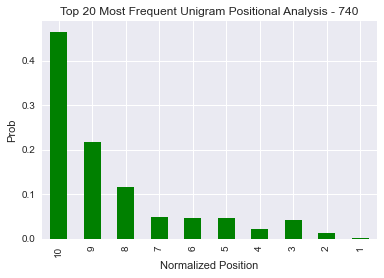

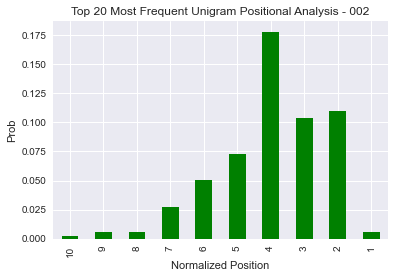

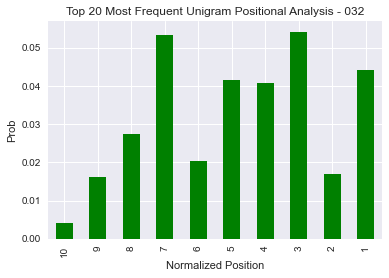

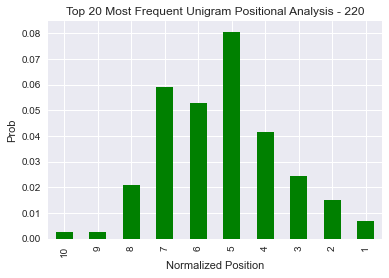

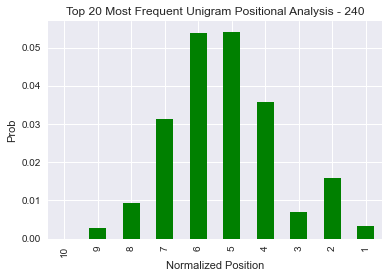

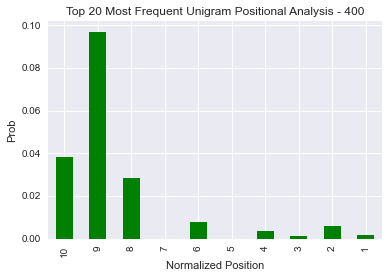

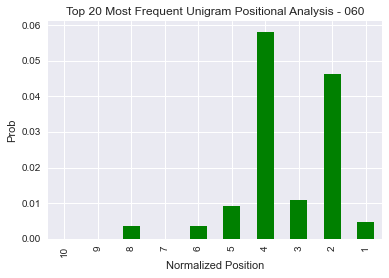

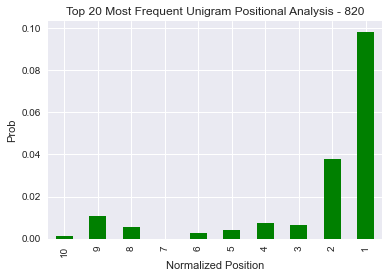

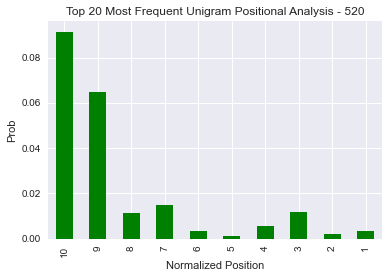

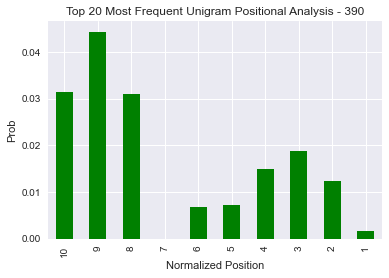

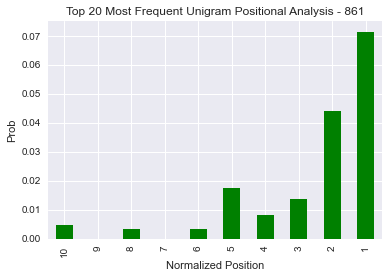

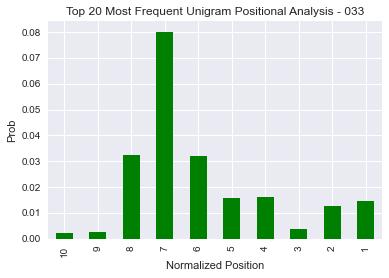

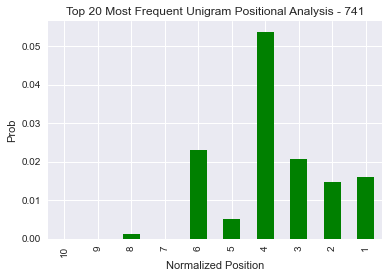

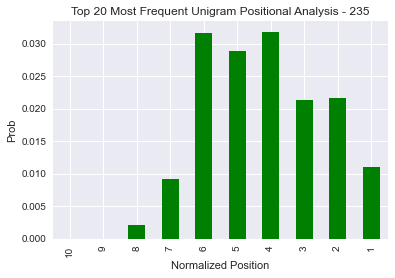

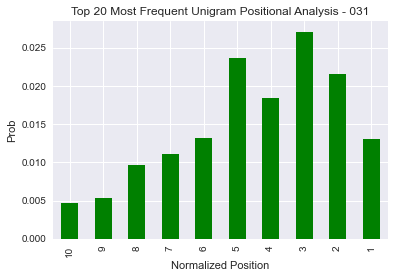

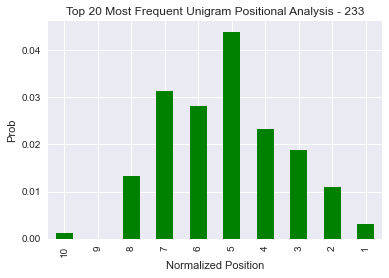

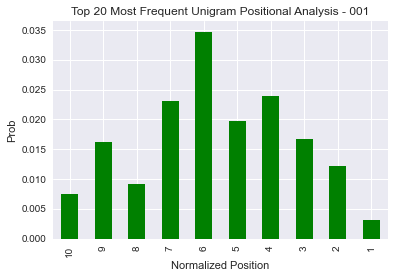

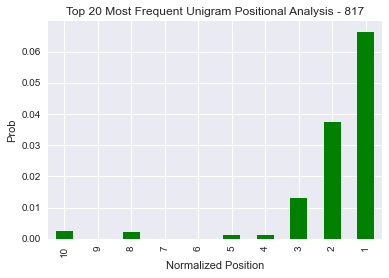

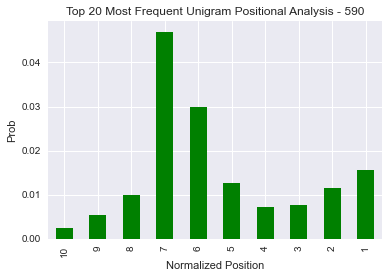

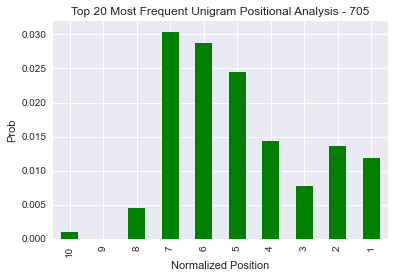

In [40]:
for unigram in pd_text_unigrams1:
    df_text_norm_position_unigrams_prob[unigram].plot(kind='bar', color='green')
    
    plt.xlabel("Normalized Position")
    plt.ylabel("Prob")
    plt.title("Top 20 Most Frequent Unigram Positional Analysis - " + unigram)

    plt.show()


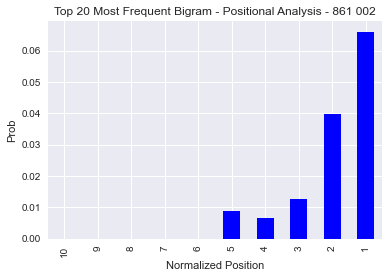

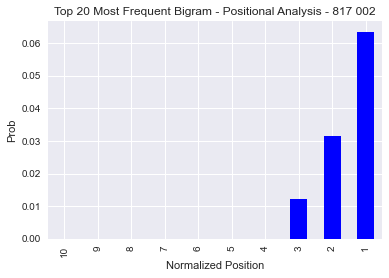

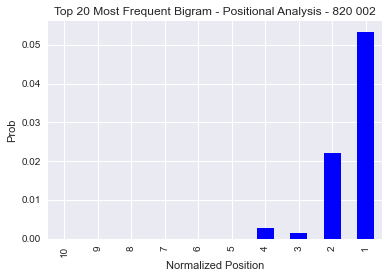

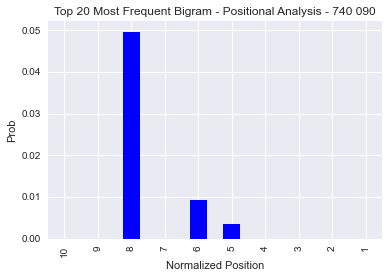

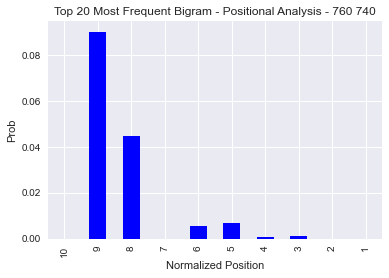

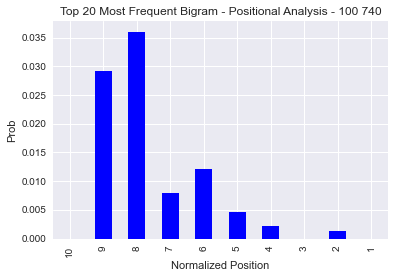

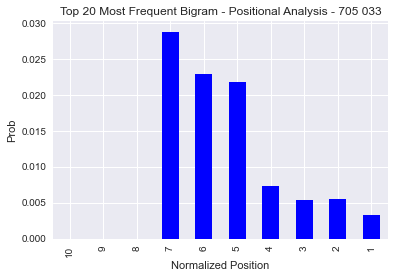

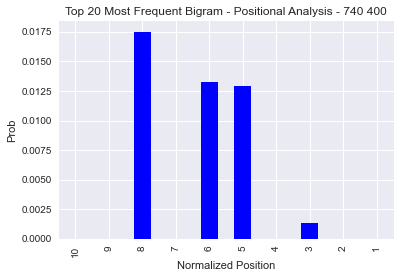

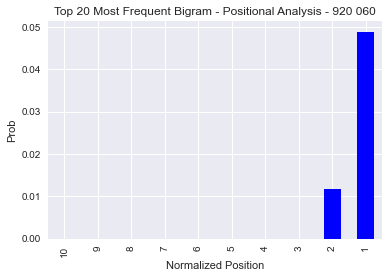

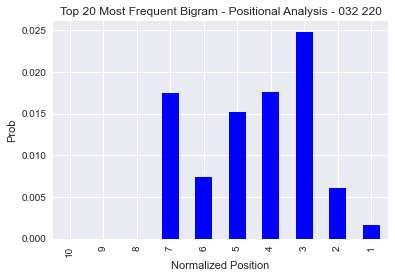

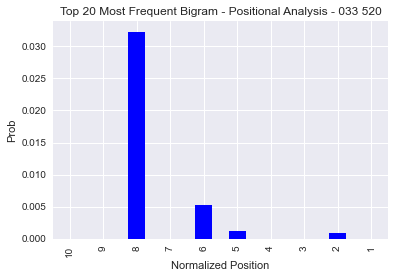

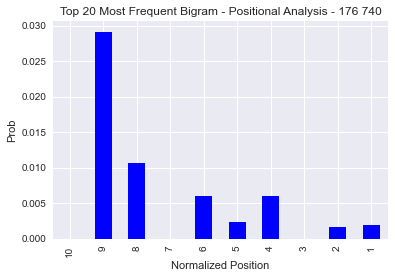

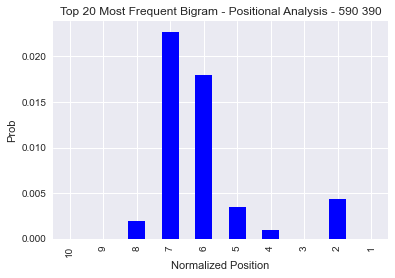

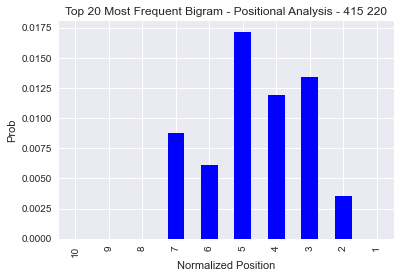

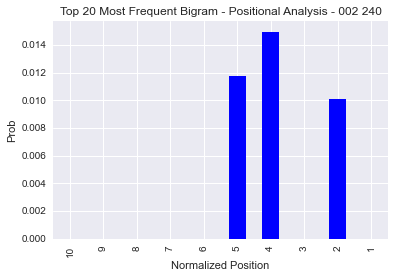

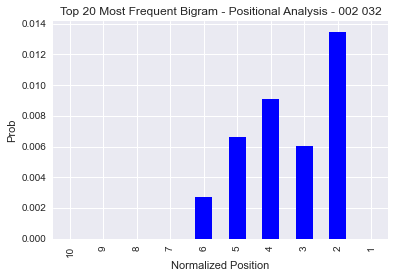

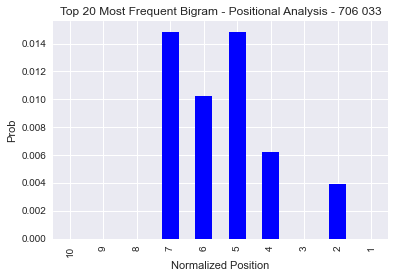

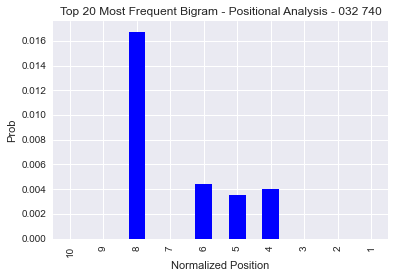

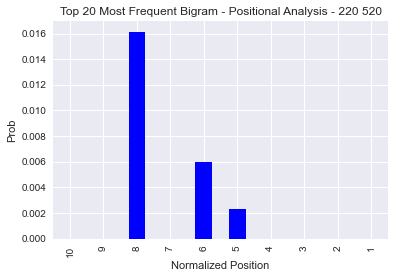

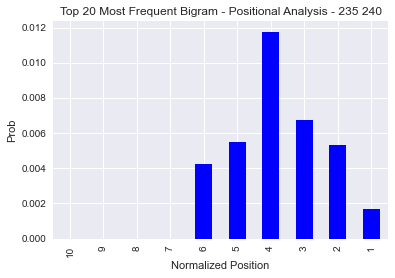

In [41]:
for bigram in pd_text_bigrams1:
    df_text_norm_position_bigrams_prob[bigram].plot(kind='bar', color='blue')
    
    plt.xlabel("Normalized Position")
    plt.ylabel("Prob")
    plt.title("Top 20 Most Frequent Bigram - Positional Analysis - " + bigram)

    plt.show()

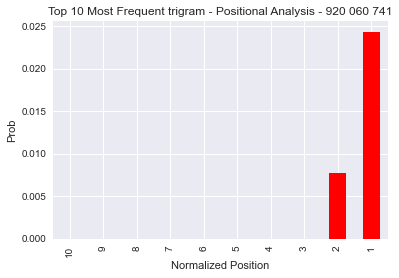

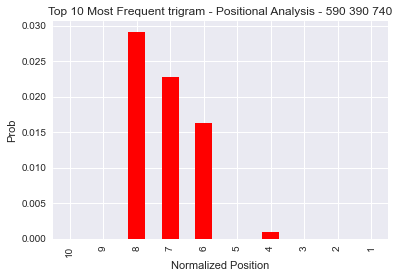

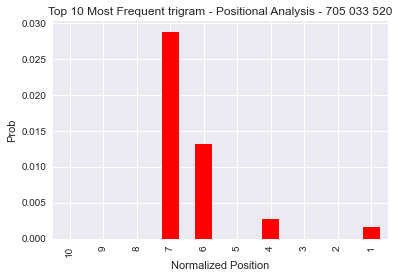

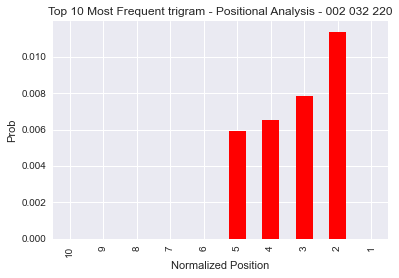

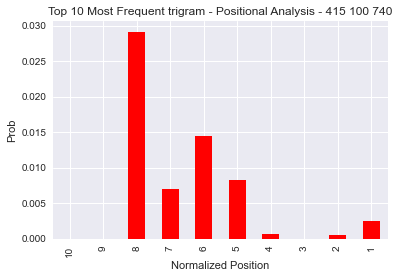

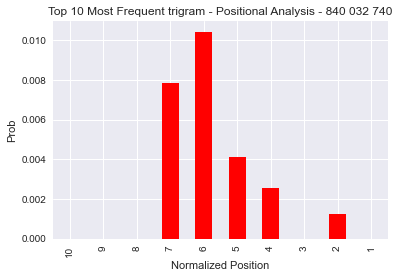

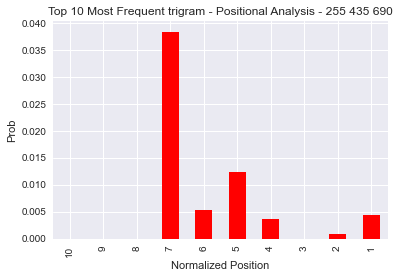

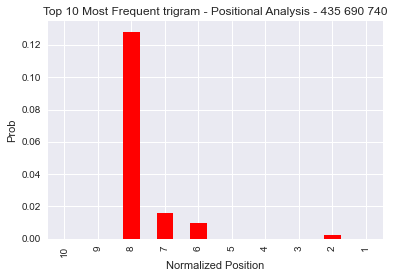

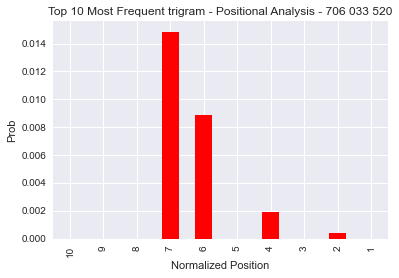

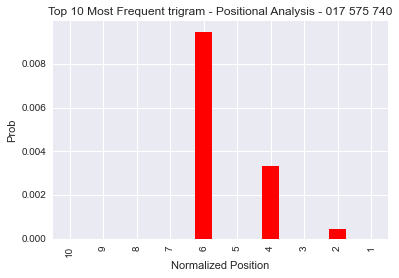

In [42]:
for trigram in pd_text_trigrams1:
    df_text_norm_position_trigrams_prob[trigram].plot(kind='bar', color='Red')
    
    plt.xlabel("Normalized Position")
    plt.ylabel("Prob")
    plt.title("Top 10 Most Frequent trigram - Positional Analysis - " + trigram)

    plt.show()

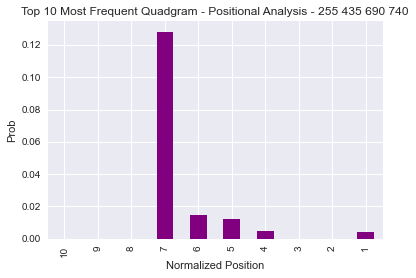

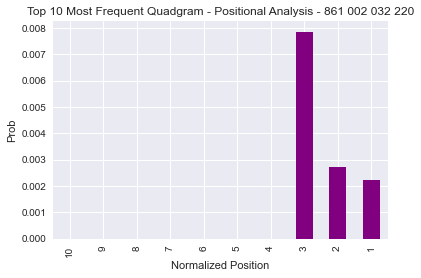

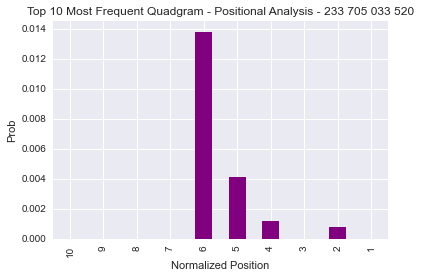

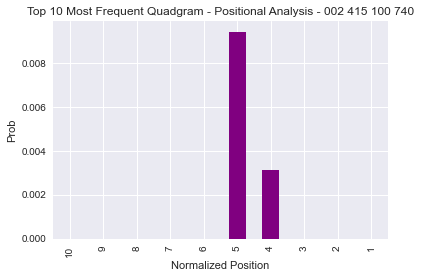

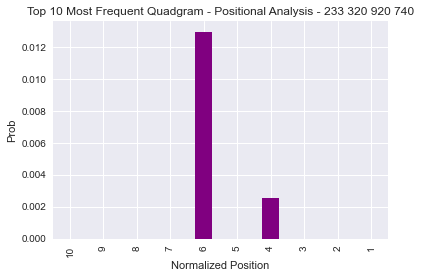

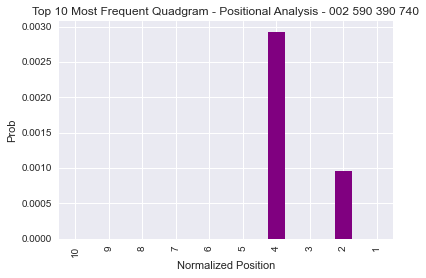

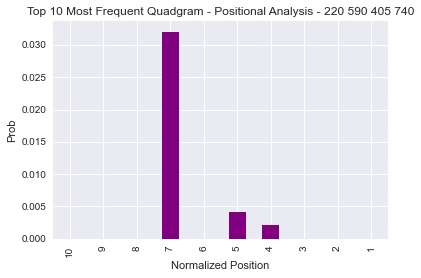

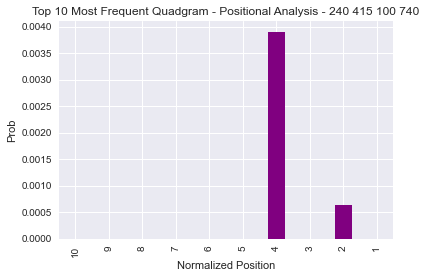

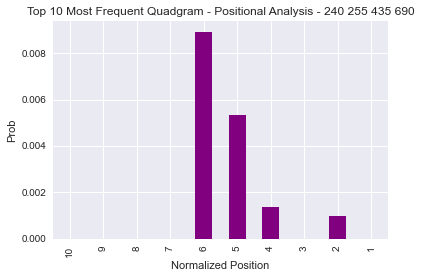

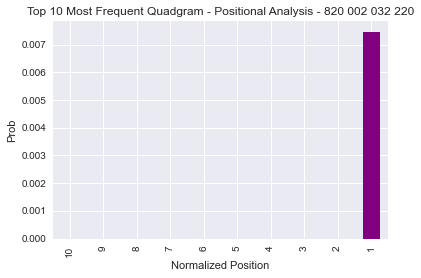

In [43]:
for quadgram in pd_text_quadgrams1:
    df_text_norm_position_quadgrams_prob[quadgram].plot(kind='bar', color='purple')
    
    plt.xlabel("Normalized Position")
    plt.ylabel("Prob")
    plt.title("Top 10 Most Frequent Quadgram - Positional Analysis - " + quadgram)

    plt.show()